## Exploring computer vision classification
1. create a basemodel with non-linear relu layers
2. Improve model using convolutional layers

In [4]:
# imports
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm

In [5]:
### set up device agnostic code
device = torch.accelerator.current_accelerator().type if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
!nvidia-smi

Mon Jun  2 04:04:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             46W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [16]:
# dataset setup
transform = torchvision.transforms.ToTensor()

train_dataset = torchvision.datasets.FashionMNIST(
 root='/content/.',
 train = True,
 transform = transform,
 download=True
)

test_dataset = torchvision.datasets.FashionMNIST(
 root='/content/.',
 train = False,
 transform=transform,
 download=True
)

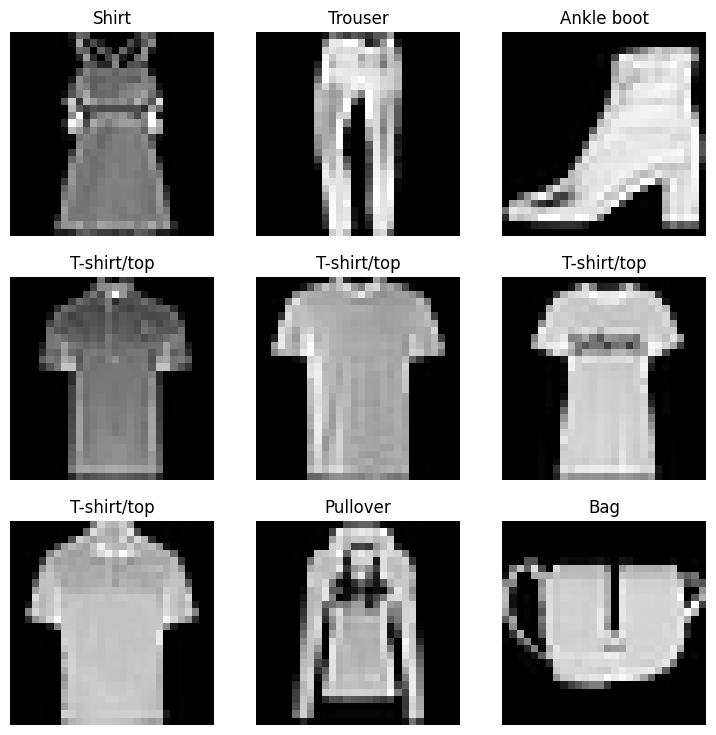

In [17]:
# visualisation of dataset
from random import randrange, seed
import matplotlib.pyplot as plt

# visualise 9 random images
fig = plt.figure(figsize=(9, 9))
seed(42)
for i in range(9):
  rand_idx = randrange(0,60000)
  img, target = train_dataset[rand_idx]
  fig.add_subplot(3, 3, i+1)
  plt.imshow(torch.permute(img, (1,2,0)), cmap='grey')
  plt.title(train_dataset.classes[target])
  plt.axis(False)

In [18]:
# train baseline linear relu model
# 1. get data: look into using the torch dataloader class
# 2. pick our model and choose a loss function and optimiser
# 3. train our model
# 4. evaluate our model
# 5. experiment
# 6. visualise visualise visualise

In [19]:
# 1. Get data
trainDataLoader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

testDataLoader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=True
)

# see exma
# import matplotlib.pyplot as plt
# visualise an example
# (X, y) = next(iter(trainDataLoader))
# print(X.shape)
# # get first example
# img = X[0]
# #img = torch.permute(img, (1,2,0)) works or...
# img = torch.squeeze(img)
# target = y[0]
# target_label = train_dataset.classes[target]
# plt.imshow(img, cmap='grey')
# plt.title(target_label)
# plt.axis(False)
# plt.show()

In [20]:
# note we will be using a flatten layer here to feed the neural network all our pixels
# img - example from previous cell
print(img.shape)
flatten_transform = nn.Flatten(0,-1)
new_img = flatten_transform(img)
print(new_img.shape)

torch.Size([1, 28, 28])
torch.Size([784])


In [21]:
# 2. Pick our base model - nonlinear relu layers only

class BaseModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.network_stack = nn.Sequential(
        nn.Linear(28*28, 32),
        nn.ReLU(),
        nn.Linear(32, 32),
        nn.ReLU(),
        nn.Linear(32, 10)
    )

  def forward(self, x):
    x = x.squeeze()
    x = self.flatten(x)
    logits = self.network_stack(x)
    return logits


In [22]:
baseModelV1 = BaseModel().to(device)

In [23]:
for param in baseModelV1.parameters():
  print(param.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [24]:
# 2. Choose a loss function and a optimiser
baseModelLoss = torch.nn.CrossEntropyLoss()
baseModelOptimiser = torch.optim.SGD(baseModelV1.parameters(), lr=0.01, momentum=0.8)

In [27]:
# 3. Train model
EPOCHS = 10
for epoch in trange(EPOCHS):
  for batch, (X, y) in enumerate(trainDataLoader):
    X = X.to(device)
    y = y.to(device)

    # training mode
    baseModelV1.train()

    # forward pass
    logits = baseModelV1(X)

    # zero gradients
    baseModelOptimiser.zero_grad()

    # loss calculation
    loss = baseModelLoss(logits, y)

    # backpropation and grad calculation
    loss.backward()

    # batch stoch grad descent step
    baseModelOptimiser.step()

  print(f'epoch: {epoch}, loss: {loss}')

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0, loss: 0.5579385161399841
epoch: 1, loss: 0.5884441137313843
epoch: 2, loss: 0.5651488900184631
epoch: 3, loss: 0.28602534532546997
epoch: 4, loss: 0.306439608335495
epoch: 5, loss: 0.5560997724533081
epoch: 6, loss: 0.21212036907672882
epoch: 7, loss: 0.1082892119884491
epoch: 8, loss: 0.0743846446275711
epoch: 9, loss: 0.2809394598007202


In [30]:
# evaluation

def model_evaluation(model, loss_fn, train_data_loader, test_data_loader, device):
  total_train_correct = 0
  total_test_correct = 0
  total_test_batch_loss = 0
  num_train_images = len(train_data_loader.dataset)
  num_test_images = len(test_data_loader.dataset)
  num_test_batches = len(test_data_loader)

  model.eval()
  # traing data
  with torch.no_grad():
    for batch, (X, y) in tqdm(enumerate(train_data_loader)):

      X = X.to(device)
      y = y.to(device)
      logits = model(X)
      loss = loss_fn(logits, y)

      total_train_correct += torch.sum((torch.argmax(logits, 1) == y)).item()

  # testing data
  with torch.no_grad():
    for batch, (X, y) in tqdm(enumerate(test_data_loader)):

      X = X.to(device)
      y = y.to(device)

      logits = model(X)
      loss = loss_fn(logits, y)

      total_test_batch_loss += loss.item()

      total_test_correct += torch.sum((torch.argmax(logits, 1) == y)).item()

  results = {
      'train_accuracy' : total_train_correct / num_train_images,
      'test_accuracy' : total_test_correct / num_test_images,
      'avg_test_batch_loss' : total_test_batch_loss / num_test_batches
  }

  return results


In [31]:
model_evaluation(
    model=baseModelV1,
    loss_fn=baseModelLoss,
    train_data_loader=trainDataLoader,
    test_data_loader=testDataLoader,
    device=device
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'train_accuracy': 0.8793833333333333,
 'test_accuracy': 0.8581,
 'avg_test_batch_loss': 0.39473430261870096}

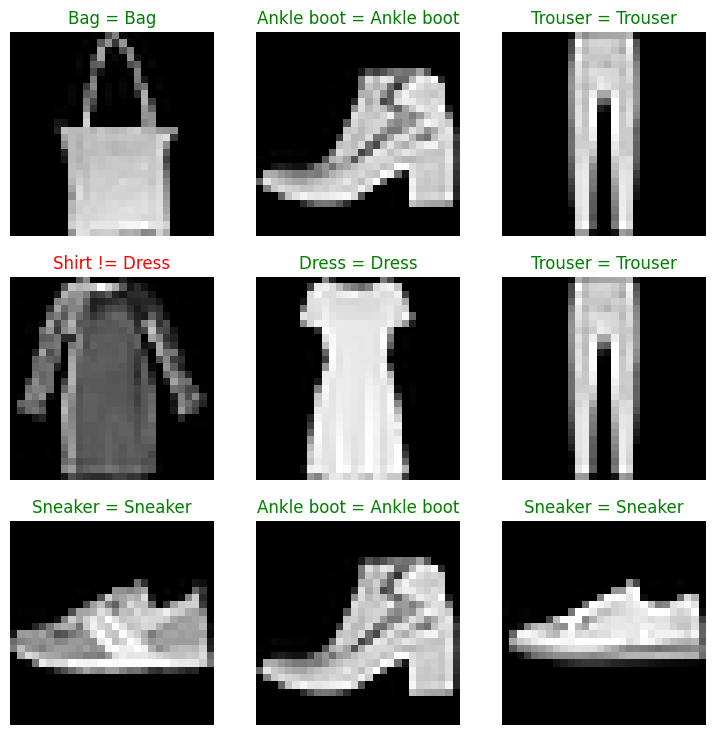

In [36]:
# Visualise visualise visualise!

def inference_examples(model, test_data_loader, rand_seed):
  torch.manual_seed(rand_seed)
  test_dataset = test_data_loader.dataset

  batch_idx = torch.randint(low=0, high=len(test_data_loader), size=(1,)).item()
  (X, y) = list(test_data_loader)[batch_idx]

  X = X.to(device)
  y = y.to(device)

  model.eval()
  with torch.no_grad():

    logits = model(X)
    preds = torch.argmax(logits, 1)

    fig = plt.figure(figsize=(9,9))
    for i in range(9):
      img_idx = torch.randint(0, len(X), (1,)).item()

      img = X[img_idx]
      pred = test_dataset.classes[preds[img_idx]]
      target = test_dataset.classes[y[img_idx]]

      if pred == target:
        color = 'green'
        symbol = '='
      else:
        color = 'red'
        symbol = '!='

      img = img.to('cpu')

      fig.add_subplot(3, 3, i+1)
      plt.imshow(img.squeeze(), cmap='grey')
      plt.title(f'{pred} {symbol} {target}', color=color)
      plt.axis(False)


inference_examples(
    model=baseModelV1,
    test_data_loader=testDataLoader,
    rand_seed=9
)

In [37]:
# save model
#torch.save(baseModelV1.state_dict(), 'baseModelV1.pth')

In [38]:
# test out conv2d
#example_tensor = torch.randn((3, 28, 28))
#layer = nn.Conv2d(3, 10, kernel_size=3)
#output_tensor = layer(example_tensor)

#print(output_tensor.shape)
#print(output_tensor)

In [39]:
# training CNN Model

class CNNModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.network_stack = nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3),
        nn.ReLU(),
        nn.Conv2d(16, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(1936, 10)
    )

  def forward(self, X):
    conv_X = self.network_stack(X)
    logits = self.classifier(conv_X)
    return logits

In [46]:
cnnModelV1 = CNNModelV1().to(device)

In [47]:
# test model forward function
#test_tensor = torch.randn(1, 1, 28, 28)
#output = cnnModelV1(test_tensor)
#output.shape

In [48]:
# choose a loss and optimiser

cnnModelV1Loss = nn.CrossEntropyLoss()
cnnModelV1Optim = torch.optim.SGD(cnnModelV1.parameters(), lr=0.01, momentum=0.9)



In [49]:
initial_results = model_evaluation(
    model=cnnModelV1,
    loss_fn=cnnModelV1Loss,
    train_data_loader=trainDataLoader,
    test_data_loader=testDataLoader,
    device=device
)

print(initial_results)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'train_accuracy': 0.11486666666666667, 'test_accuracy': 0.114, 'avg_test_batch_loss': 2.3037683341153867}


In [50]:
# training
from tqdm.notebook import tqdm, trange

EPOCHS = 10
total_num_batches = len(trainDataLoader)

#put in training mode
cnnModelV1.train()
for epoch in trange(EPOCHS):

  batch_total_loss = 0
  for batch, (X, y) in tqdm(enumerate(trainDataLoader)):

    X = X.to(device)
    y = y.to(device)

    # forward pass on batch
    logits = cnnModelV1(X)
    # calculate loss
    loss = cnnModelV1Loss(logits, y)
    # zero gradients before calculation
    cnnModelV1Optim.zero_grad()
    # calcualte backpropagation and gradients
    loss.backward()
    # apply batch stochastic gradient descent
    cnnModelV1Optim.step()

    batch_total_loss += loss

  print(epoch, f'average batch loss {batch_total_loss / total_num_batches:.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0 average batch loss 0.6130


0it [00:00, ?it/s]

1 average batch loss 0.3628


0it [00:00, ?it/s]

2 average batch loss 0.3163


0it [00:00, ?it/s]

3 average batch loss 0.2878


0it [00:00, ?it/s]

4 average batch loss 0.2690


0it [00:00, ?it/s]

5 average batch loss 0.2560


0it [00:00, ?it/s]

6 average batch loss 0.2443


0it [00:00, ?it/s]

7 average batch loss 0.2354


0it [00:00, ?it/s]

8 average batch loss 0.2294


0it [00:00, ?it/s]

9 average batch loss 0.2214


In [52]:
trained_results = model_evaluation(
    model=cnnModelV1,
    loss_fn=cnnModelV1Loss,
    train_data_loader=trainDataLoader,
    test_data_loader=testDataLoader,
    device=device
)

print(trained_results)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'train_accuracy': 0.9189166666666667, 'test_accuracy': 0.8992, 'avg_test_batch_loss': 0.29238146984842933}


In [ ]:
# improved model with CNN layers
# high train accuracy compared to test suggests overfitting

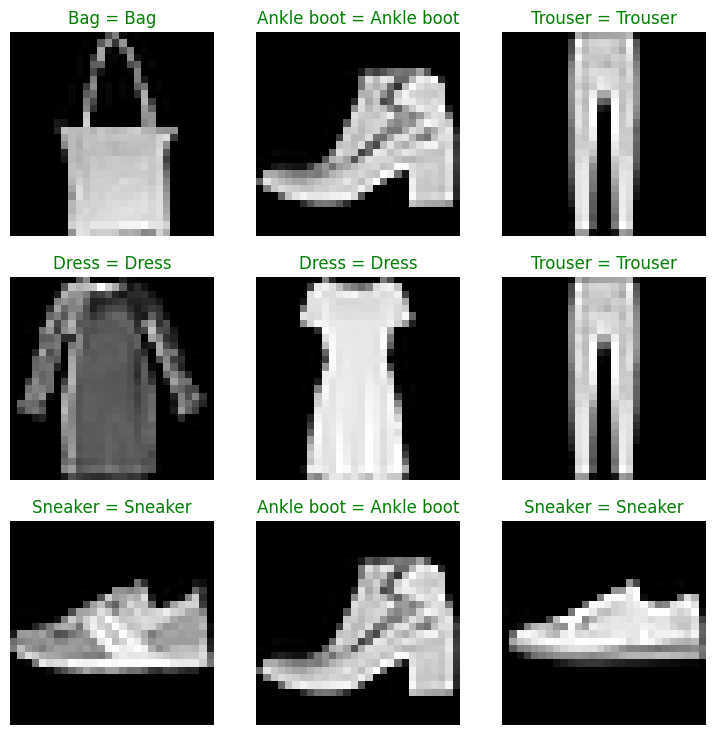

In [53]:
# visualisation
inference_examples(
    model=cnnModelV1,
    test_data_loader=testDataLoader,
    rand_seed=9
)